In [1]:
import torch
import numpy as np
import normflows as nf

import sys
import os
c_directory = os.getcwd()
sys.path.append(os.path.dirname(c_directory))

import architecture
import FCYeast_simulator

from matplotlib import pyplot as plt

enable_cuda = True
CUDA_LAUNCH_BLOCKING=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
N = 2**12

seed_data = 29
seed_mcmc = 42
torch.manual_seed(seed_mcmc)

In [3]:
dv = np.loadtxt('FCYeast_synth/gt_map.csv')
gt = torch.tensor( dv[ dv[:,0]==seed_data ][0,1:] , device=device,dtype=torch.float)

x = np.loadtxt('FCYeast_synth/synth_{}.csv'.format(seed_data))[:N]
x = torch.tensor(x,device=device,dtype=torch.float).reshape(-1,1)
gt

tensor([13.4422, -0.1417,  0.4743, -2.2562], device='cuda:0')

In [4]:
FCYeast_simulator.adjust_device(device)
target = FCYeast_simulator.target()

model = architecture.make_model(device=device)
model_file = 'FCYeast_network.pt'

In [5]:
for param in model.parameters():
    param.requires_grad = False

In [6]:
try:
    model.load_state_dict(torch.load(model_file))
    #model.eval()  # Set the model to evaluation mode
    print('loading pretrained network')
except:
    print('starting from scratch')

loading pretrained network


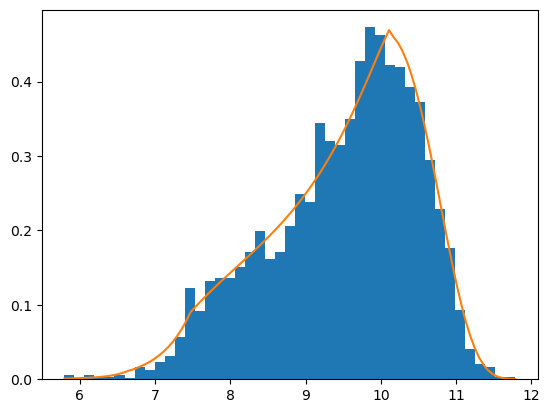

In [7]:
plt.hist(x.reshape(-1).cpu(), density=True,bins=45)

xp = torch.linspace(x.min(),x.max(),101).to(device)
lp = model.log_prob(xp.reshape(-1,1),torch.ones((101,4),device=device)*gt)
p = torch.exp(lp-lp.max())
p *= 1/(p.sum()*(xp[1]-xp[0]))
plt.plot(xp.cpu(),p.detach().cpu())

In [8]:
vectorize_params = torch.ones(1024,4).to(device)

def log_likelihood(data,params,model):
    global vectorize_params
    if data.size !=  vectorize_params.size(0):
        vectorize_params = torch.ones((data.size(0),4),device=device)

    return model.log_prob(data,params*vectorize_params)

def log_post(data,params,model,lprior):
    return log_likelihood(data,params,model).sum() + lprior(params)


In [9]:
lp_gt = log_post(x,gt,model,target.log_prior)
lp_gt

tensor(-5486.4478, device='cuda:0')

In [10]:
#first 100 from prior
params_100 = target.sample(n=100)[:,1:]
best_param = params_100[0]
lp_max = log_post(x,best_param,model,target.log_prior)

for par in params_100[1:]:
    lp_par = log_post(x,par,model,target.log_prior)
    if lp_par>lp_max:
        best_param = par
        lp_max=lp_par

for i in range(3,8):

    params_100 = (target.sample(n=100)[:,1:] - best_param)/i +best_param

    for par in params_100:
        lp_par = log_post(x,par,model,target.log_prior)
        if lp_par>lp_max:
            best_param = par
            lp_max=lp_par
            print(best_param,lp_max)


del params_100

tensor([12.9146, -0.5574, -0.5421, -1.6874], device='cuda:0') tensor(-5626.9556, device='cuda:0')
tensor([13.3515, -0.6263, -0.2405, -1.7769], device='cuda:0') tensor(-5603.2827, device='cuda:0')
tensor([13.2932, -0.4246, -0.2256, -1.4108], device='cuda:0') tensor(-5549.1738, device='cuda:0')
tensor([12.9845, -0.4510, -0.6928, -1.5436], device='cuda:0') tensor(-5517.7515, device='cuda:0')
tensor([13.1256, -0.4379, -0.4480, -1.8074], device='cuda:0') tensor(-5510.9712, device='cuda:0')
tensor([13.1105, -0.4480, -0.4004, -1.9206], device='cuda:0') tensor(-5506.6299, device='cuda:0')
tensor([13.2010, -0.2913, -0.0987, -1.8069], device='cuda:0') tensor(-5493.7310, device='cuda:0')


In [11]:
param = best_param
lp = lp_max

sampled_params = [param.cpu()]
sampled_logpost = [lp.cpu().item()]

In [12]:
S = torch.eye(4)*1e-4
mvn = torch.distributions.MultivariateNormal(torch.zeros(4,device=device),S.to(device))

def change_S(newS):
    global S
    global mvn

    S = newS
    mvn = torch.distributions.MultivariateNormal(torch.zeros(4,device=device),S.to(device))

def proposal(param):
    return param + mvn.sample()

In [13]:
count_of_safe=0
loopruns = 0

while count_of_safe <=10:
    for i in range(150):
        param_prop = proposal(param)
        lp_prop = log_post(x,param_prop,model,target.log_prior)

        if torch.log(torch.rand(1))< (lp_prop-lp).item():
            param = param_prop
            lp = lp_prop

        sampled_params.append(param.cpu())
        sampled_logpost.append(lp.cpu().item())

        #print(param_prop)

    acc_rate = np.mean([(sampled_params[i] - sampled_params[i-1]).sum().item()!=0 for i in range(-1,-101,-1)])

    if acc_rate>.2 and acc_rate<.5:
        count_of_safe += 1
    else:
        count_of_safe = 0

    if loopruns%3==2:
        change_S( (torch.stack(sampled_params[-200:]).T.cov() + torch.eye(4)*1e-10) * ((2.4**2)/4)) 
    loopruns+=1

    print(loopruns,acc_rate,lp)
    



1 0.73 tensor(-5489.5371, device='cuda:0')
2 0.67 tensor(-5486.8237, device='cuda:0')
3 0.68 tensor(-5489.8735, device='cuda:0')
4 0.47 tensor(-5489.1782, device='cuda:0')
5 0.49 tensor(-5487.5454, device='cuda:0')
6 0.52 tensor(-5486.4370, device='cuda:0')
7 0.44 tensor(-5485.6748, device='cuda:0')
8 0.4 tensor(-5486.0615, device='cuda:0')
9 0.41 tensor(-5485.2617, device='cuda:0')
10 0.33 tensor(-5488.7368, device='cuda:0')
11 0.31 tensor(-5488.3062, device='cuda:0')
12 0.3 tensor(-5485.1338, device='cuda:0')
13 0.35 tensor(-5486.0952, device='cuda:0')
14 0.3 tensor(-5486.5132, device='cuda:0')
15 0.38 tensor(-5485.5024, device='cuda:0')
16 0.3 tensor(-5485.6909, device='cuda:0')
17 0.35 tensor(-5488.7793, device='cuda:0')


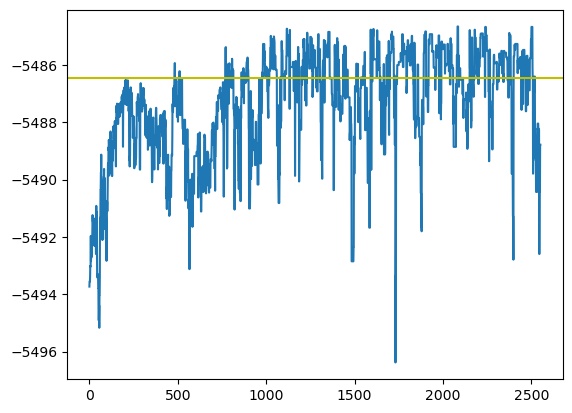

In [14]:
plt.plot(sampled_logpost)
plt.axhline(lp_gt.item(),color='y')

In [15]:
burnin = len(sampled_logpost)
for i in range(100000):
    param_prop = proposal(param)
    lp_prop = log_post(x,param_prop,model,target.log_prior)

    if torch.log(torch.rand(1))< (lp_prop-lp).item():
        param = param_prop
        lp = lp_prop

    sampled_params.append(param.cpu())
    sampled_logpost.append(lp.cpu().item())

    if i%100 == 99:
        print(i,param,lp)
        #print(i,param,lp)

99 tensor([ 1.3527e+01,  9.7446e-03,  7.6063e-01, -3.7190e+00], device='cuda:0') tensor(-5489.3193, device='cuda:0')
199 tensor([13.5759, -0.0548,  0.7706, -2.6383], device='cuda:0') tensor(-5486.0723, device='cuda:0')
299 tensor([13.3803, -0.1354,  0.4070, -1.4228], device='cuda:0') tensor(-5486.9536, device='cuda:0')
399 tensor([ 1.3536e+01,  7.5169e-03,  7.5635e-01, -2.4471e+00], device='cuda:0') tensor(-5487.2681, device='cuda:0')
499 tensor([13.6774,  0.0373,  1.0345, -3.0578], device='cuda:0') tensor(-5487.1802, device='cuda:0')
599 tensor([13.5041, -0.0844,  0.6822, -2.4164], device='cuda:0') tensor(-5486.3003, device='cuda:0')
699 tensor([13.3949, -0.1899,  0.3739, -2.1063], device='cuda:0') tensor(-5487.0679, device='cuda:0')
799 tensor([13.4883, -0.1247,  0.5489, -3.0250], device='cuda:0') tensor(-5489.5879, device='cuda:0')
899 tensor([13.5443, -0.0315,  0.7535, -2.5599], device='cuda:0') tensor(-5484.9224, device='cuda:0')
999 tensor([13.4381, -0.0668,  0.5270, -3.0416], de

In [16]:
np.savetxt('FCYeast_mcmc/results_{}seed_{}data_{}dp.csv'.format(seed_mcmc,seed_data,N),
           np.hstack((np.stack(sampled_params), np.array(sampled_logpost).reshape(-1,1))))

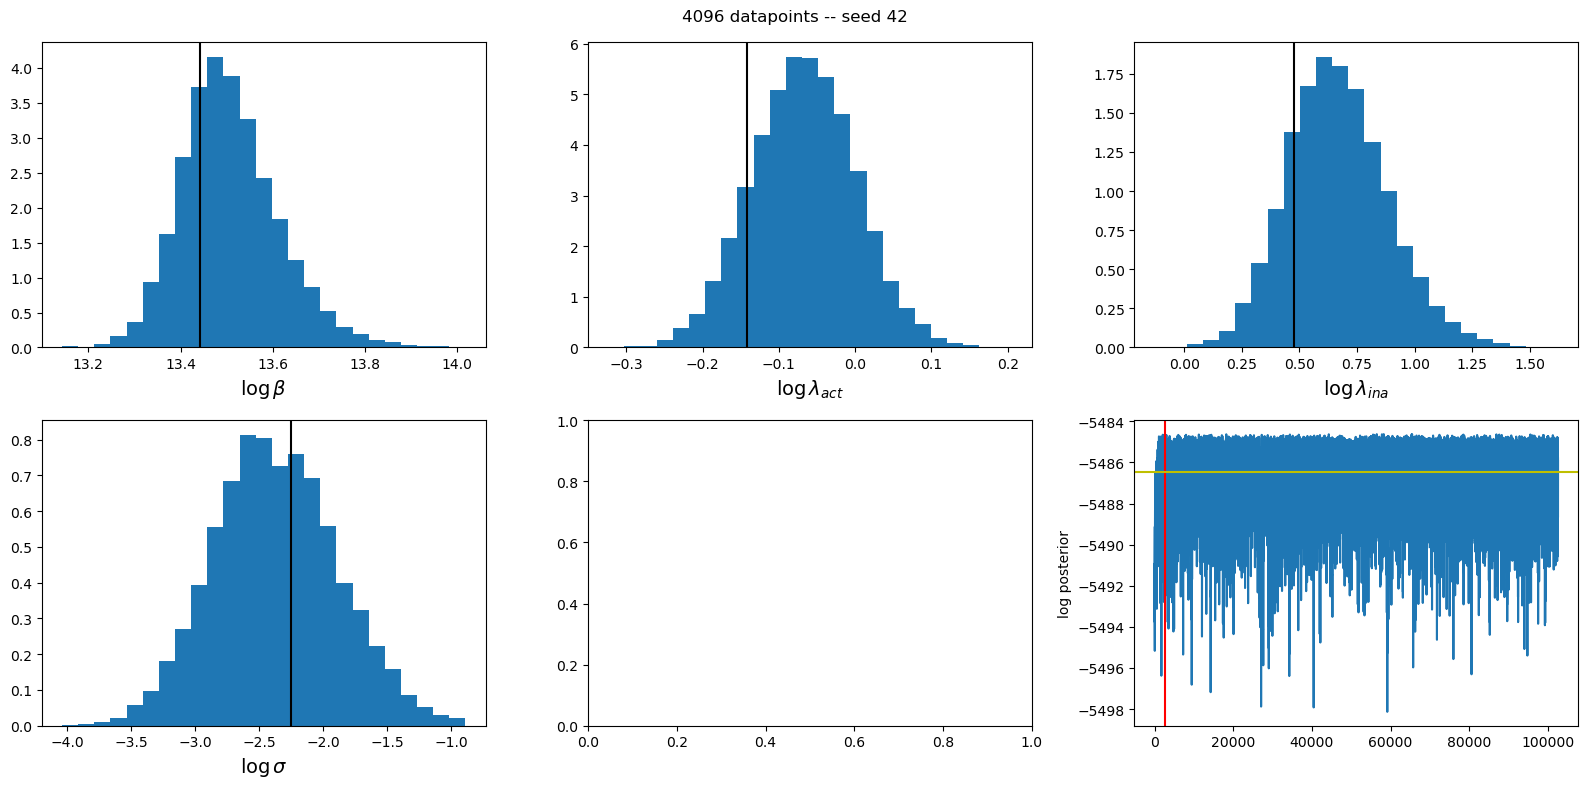

In [18]:
fig, ax = plt.subplots(2,3,figsize=(16,8))
labels = [r'$\log \beta$',r'$\log {\lambda_{act}}$',r'$\log {\lambda_{ina}}$',r'$\log \sigma$',r'$\log k$']
sp = torch.stack(sampled_params).numpy()

for (i,axi) in zip(range(4),ax.reshape(-1)):
    his = axi.hist(sp[burnin:burnin+sp.shape[0]//2,i],density=True,bins=25)
    #axi.hist(sp[burnin+sp.shape[0]//2:,i],density=True,bins=his[1],alpha=.5)
    #axi.hist(sp[burnin:,i],density=True,bins=25)
    axi.axvline(gt.cpu()[i].item(),color='k')
    axi.set_xlabel(labels[i],fontsize=14)

ax[-1][-1].plot(sampled_logpost)
ax[-1][-1].axvline(burnin,color='red')
ax[-1][-1].axhline(lp_gt.item(),color='y')

ax[-1][-1].set_ylabel('log posterior')

plt.suptitle('{} datapoints -- seed {}'.format(N,seed_mcmc))

plt.tight_layout()
plt.savefig('FCYeast_mcmc/fig_posterior/mcmc_noncentral_{}_{}data_{}dp.png'.format(seed_mcmc,seed_data,N),dpi=600)

In [19]:
map_param = sampled_params[np.argmax(sampled_logpost)].to(device)
map_param

tensor([13.4919, -0.0681,  0.6483, -2.4451], device='cuda:0')

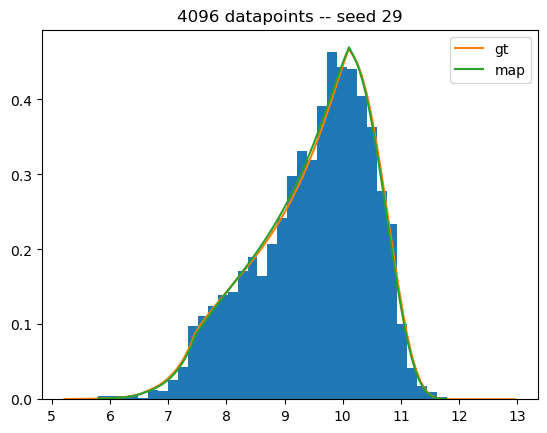

In [22]:
plt.hist(x.reshape(-1).cpu(), density=True,bins=35)

xp = torch.linspace(.9*x.min(),1.1*x.max(),101).to(device)
lp = model.log_prob(xp.reshape(-1,1),torch.ones((101,4),device=device)*gt)
p = torch.exp(lp-lp.max())
p *= 1/(p.sum()*(xp[1]-xp[0]))
plt.plot(xp.cpu(),p.detach().cpu(),label='gt')

xp = torch.linspace(x.min(),x.max(),101).to(device)
lp = model.log_prob(xp.reshape(-1,1),torch.ones((101,4),device=device)*map_param)
p = torch.exp(lp-lp.max())
p *= 1/(p.sum()*(xp[1]-xp[0]))
plt.plot(xp.cpu(),p.detach().cpu(),label='map')
plt.legend()

plt.title('{} datapoints -- seed {}'.format(N,seed_data))

plt.savefig('FCYeast_mcmc/fig_comparison/mcmc_compare_{}_{}data_{}dp.png'.format(seed_mcmc,seed_data,N),dpi=600)